__Title:__ Active Learning  
__Authors:__ Pablo Carrera Flórez de Quiñones & José Llanes Jurado  
__Subject:__ Machine Learning II  
__Titulation__: Máster en Ciencia de Datos    
__University__: Universitat de València  

# Introduction

In this work we are going to get hands-on experience on some of the Active Learning methods studied on the class of Machine Learning II with the Semeion Handwritten Digit dataset. It is available at the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Semeion+Handwritten+Digit) and it contains 1593 digitalized images of handwritten digits in 16x16 size (256 pixels). Our goal in this work is to develop a classifier based on these Active Learning methods and then evaluate its perfomance.

# Libraries

First we import all the libraries that we are going to use 

In [1]:
# Basics
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import resample
from sklearn.cluster import KMeans

# Other
from scipy.spatial.distance import pdist
from ipywidgets import interact, fixed
from al_base import ao

# Data

And now we import the data. Since all data files have the same formating we can create a function to import them correctly:
* Rows are images of numbers labeled with the number that they are representing.
* The first column is the label of the image.
* The other 256 columns are the pixels of the images, 0 is off and 1 is on.

In [2]:
def import_data(filepath):
    # Import data
    df = pd.read_csv(filepath, header = None)

    # Put labels at the end
    label = df.iloc[:,0]
    df = df.drop(df.columns[0], axis = 1)
    df = pd.concat([df, label], axis = 1)

    # Name the columns
    names = [str(i) for i in range(256)]
    names.append("label")
    df.columns = names

    return df

and then apply it to the files

In [3]:
semeion_labeled   = import_data(filepath = "data/semeion_labeled.csv")
semeion_unlabeled = import_data(filepath = "data/semeion_unlabeled.csv")
semeion_test      = import_data(filepath = "data/semeion_test.csv")

We can start by exploring the dimension

In [4]:
print("Dimensions of semeion_labeled:", semeion_labeled.shape)
print("Dimensions of semeion_unlabeled:", semeion_unlabeled.shape)
print("Dimensions of semeion_test:", semeion_test.shape)

Dimensions of semeion_labeled: (10, 257)
Dimensions of semeion_unlabeled: (945, 257)
Dimensions of semeion_test: (638, 257)


the unique elements

In [5]:
print("Uniques of semeion_labeled:  ", sorted(semeion_labeled.label.unique().tolist()))
print("Uniques of semeion_unlabeled:", sorted(semeion_unlabeled.label.unique().tolist()))
print("Uniques of semeion_test:     ", sorted(semeion_test.label.unique().tolist()))

Uniques of semeion_labeled:   [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Uniques of semeion_unlabeled: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Uniques of semeion_test:      [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


and the distribution of the labels

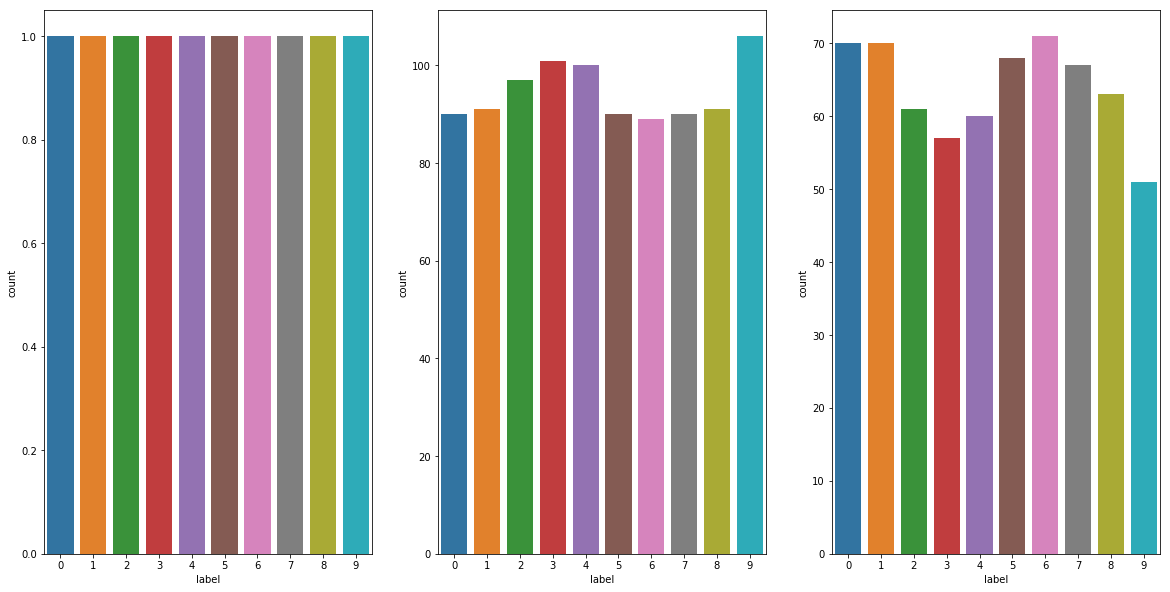

In [6]:
plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
sns.countplot(x = semeion_labeled.label)
plt.subplot(1,3,2)
sns.countplot(x = semeion_unlabeled.label)
plt.subplot(1,3,3)
sns.countplot(x = semeion_test.label)
plt.show()

so we can see that there is no imbalances between the labels.

Finally we can also define a function that allow us to inspect how a specific image looks like

In [7]:
def show_image(data, index):
    print("Label: ", data.iloc[index,256])
    plt.imshow(data.iloc[index,:-1].values.reshape((16,16)))
    
interact(lambda **kwargs: show_image(semeion_labeled, **kwargs), index=(0,8))
plt.show()

interactive(children=(IntSlider(value=4, description='index', max=8), Output()), _dom_classes=('widget-interac…

# Classification by Active Learning

Now we are going to study some Active Learning strategies. In order to test the different strategies we are going to define an algorithm that query labels at random, so we can use it as a benchmark for the efectivity of each strategy. First we initialize the active learning with the labeled data in `semeion_labeled`, then we create the pool of unlabeled data with `semeion_unlabeled` and the we create the test data with `semeion_test`.

In [8]:
active_object = ao()

# Create the labeled, unlabeled and test objects
active_object.xlab = np.array(semeion_labeled.drop("label", axis = 1))
active_object.ylab = np.array(semeion_labeled.label)
active_object.xunlab = np.array(semeion_unlabeled.drop("label", axis = 1))
active_object.yunlab = np.array(semeion_unlabeled.label)
X_test = np.array(semeion_test.drop("label", axis = 1))
y_test = np.array(semeion_test.label)

# Tune the model
sigma = np.mean(pdist(active_object.xlab))
active_object.gamma = 1 / (2 * sigma * sigma)
active_object.classifier = SVC(C=active_object.C, gamma=active_object.gamma, decision_function_shape='ovr')

active_object.idx = []
active_object.acc = []

# Perpare two objects for the functions
random = active_object.copy()
active = active_object.copy()

and now define the parameters of the Active Learning strategies

In [9]:
n_classes = len(np.unique(active_object.ylab))
num_queries = 50
query_points = 10

so we are doing up to `num_queries` of `query_points` at a time.

## Random Sampling

First we define the random model, here the points to query are selected at random. For studying how the different queries improve the accuracy of the model we are goint to save the value of the accuracy after updating the model with one point at a time

In [10]:
def classifier_random(X_test, y_test, num_queries, query_points, random_object):
    
    label = "Random"
    random = random_object.copy()
    for i in range(num_queries):
        
        # Fit and save the accuracy
        random.classifier.fit(random.xlab, random.ylab)
        acc = random.classifier.score(X_test, y_test)
        random.acc.append(acc)
        
        # Choose the points to query
        idx = np.random.permutation(random.xunlab.shape[0])
        
        # Update the training set
        random.updateLabels(idx[:query_points])
    
    return random, label

and looking how it performs

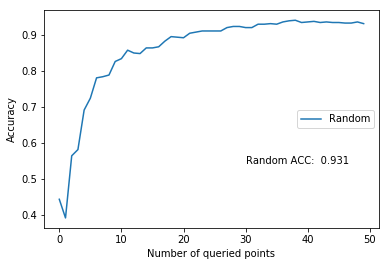

In [11]:
al_object_rand, label_rand = classifier_random(X_test, y_test, num_queries, query_points, random)

plt.plot(al_object_rand.acc, label = label_rand)
plt.xlabel("Number of queried points")
plt.ylabel("Accuracy")
plt.legend(loc = "center right")
plt.text(x = 30, y = al_object_rand.acc[0] + 0.1, s = "Random ACC: %6.3f" % (al_object_rand.acc[-1]))
plt.show()

we can see that it reaches an accuracy of almost 95% with 50 queries of 10 labels.

We can also see the distribution of the queried labels

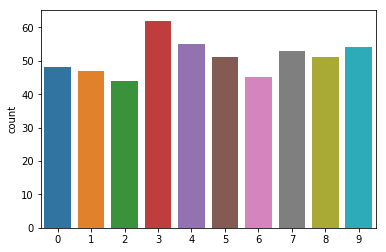

In [12]:
sns.countplot(x = al_object_rand.ylab)
plt.show()

which is more or less that we could expect from a random selection.

## Uncertainty Sampling

In this framework, an active learner queries the instances about which it is least certain how to label.

### MS

The most straightforward way of start doing this is Margin Sampling (MS), that consist in to query the points that are the closest to the classification boundaries

In [13]:
def classifier_MS(X_test, y_test, num_queries, query_points, active_object):
    
    label = "MS"
    active = active_object.copy()
    for i in range(num_queries):
        
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        dist = np.abs(active.classifier.decision_function(active.xunlab))
        dist = np.sort(dist, axis=1)
        dist = [d[0] for d in dist]
        idx = np.argsort(dist, axis = 0)
        
        # Update the training set
        active.updateLabels(idx[:query_points])
    
    return active, label

and for looking how it performs we can study how the accuracy of the model evolves when compared with the random benchmark model. It is also interesting to see the distribution of the queries in order to see how the different labels are learned  by the model. 

In [14]:
def plot_comparation(random_object, label_rand, active_object, label_al):
    plt.plot(random_object.acc, label = label_rand)
    plt.plot(active_object.acc, label = label_al)
    plt.xlabel("Number of queries")
    plt.ylabel("Accuracy")
    plt.title("{} vs. {}".format(label_al, label_rand))
    plt.legend(loc = "center right")
    plt.text(x = 30, y = random_object.acc[0] + 0.1,  s = "Random ACC: %6.3f" % (random_object.acc[-1]), fontsize = 15)
    plt.text(x = 30, y = random_object.acc[0] + 0.05, s = "Active ACC: %6.3f" % (active_object.acc[-1]), fontsize = 15)
    
def plot_queries(al_object):
    sns.countplot(x = al_object.ylab)
    plt.xlabel("Number queried")
    plt.ylabel("Counts")
    plt.title("Distribution of queries")
    
def full_plots(random_object, label_rand, active_object, label_al):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plot_comparation(random_object, label_rand, active_object, label_al)
    plt.subplot(1,2,2)
    plot_queries(active_object)
    plt.show()

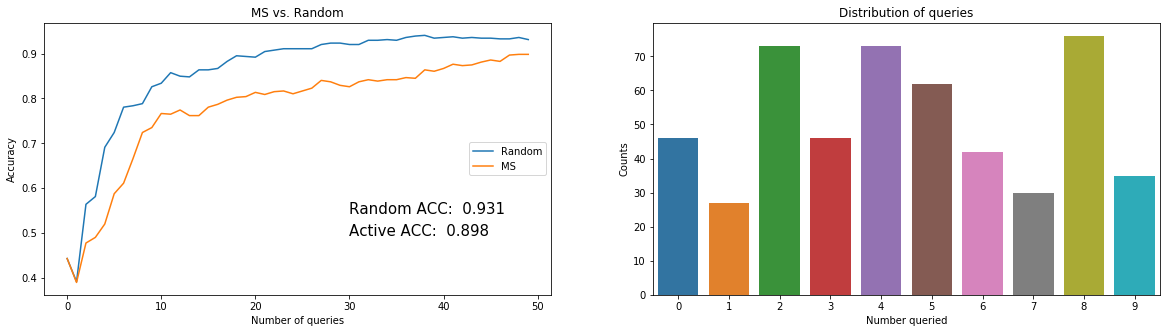

In [15]:
al_object_ms, label_ms = classifier_MS(X_test, y_test, num_queries, query_points, active)
full_plots(al_object_rand, label_rand, al_object_ms, label_ms)

### MCLU

However this method does not work much better that random in multiclass problems. A variant of this method considers not only the closest boundary to a point but also the next closests boundary, in such a way that we query the points that are likely to pertain to different classes with more o less the same probability. 

In [16]:
def classifier_MCLU(X_test, y_test, num_queries, query_points, active_object):
    
    label = "MCLU"
    active = active_object.copy()
    for i in range(num_queries):
               
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        dist = np.abs(active.classifier.decision_function(active.xunlab))
        dist = np.sort(dist, axis = 1)
        dist = [d[1] - d[0] for d in dist][::-1]
        idx = np.argsort(dist, axis = 0)

        # Update the training set
        active.updateLabels(idx[:query_points])
    
    return active, label

and looking how it performs

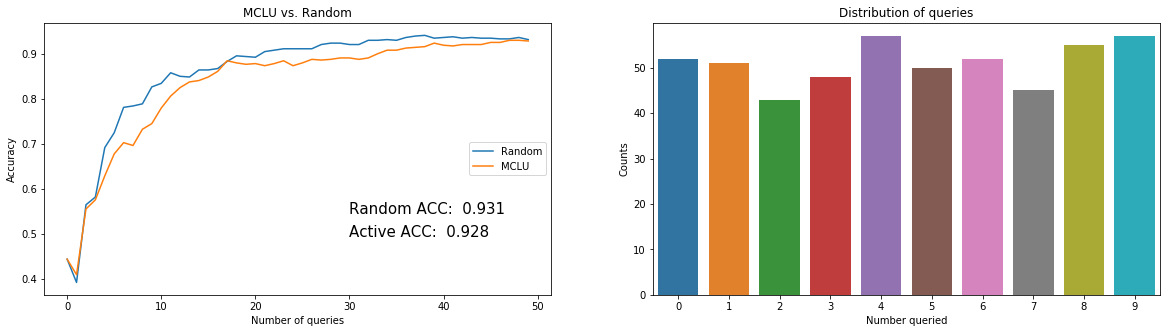

In [17]:
al_object_mclu, label_mclu = classifier_MCLU(X_test, y_test, num_queries, query_points, active)
full_plots(al_object_rand, label_rand, al_object_mclu, label_mclu)

### SSC

Another framework to query is Significance Space Construction (SSC). Here training samples related to support vector coeficients are used to define a second classification function, where training samples that became support vectors are classified against the rest of training samples. This second classifier predicts which samples are likely to become support vectors, which are knonw to be the most informative samples, and query from them.

In [18]:
def classifier_SSC(X_test, y_test, num_queries, query_points, active_object):
    
    label = "SSC"
    active = active_object.copy()
    model = SVC(C = active.C, gamma = active.gamma)
    for i in range(num_queries):
        
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        xtr = active.xlab
        ytr = np.zeros(active.ylab.shape)
        ytr[active.classifier.support_] = 1
        
        if len(np.unique(ytr)) == 1:
            idx = np.random.permutation(active.xunlab.shape[0])
        else:
            model.fit(xtr, ytr)
            possible_SVs = model.predict(active.xunlab)
            idx = np.arange(active.xunlab.shape[0])[possible_SVs == 1]
            idx = np.random.permutation(idx)
        
        # Update the training set
        active.updateLabels(idx[:query_points])
    
    return active, label

and looking how it performs

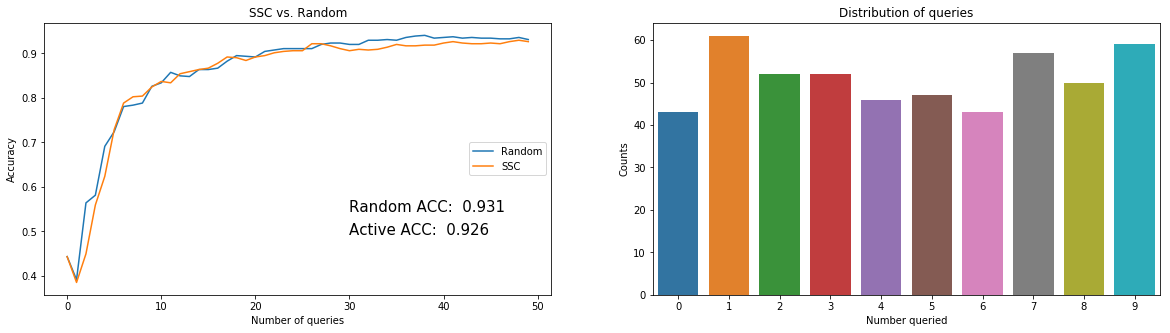

In [19]:
al_object_ssc, label_scc = classifier_SSC(X_test, y_test, num_queries, query_points, active)
full_plots(al_object_rand, label_rand, al_object_ssc, label_scc)

## Committe Sampling

The QBC approach involves maintaining a committee $\mathcal{C} = \{ \theta^{(1)}, ... , \theta^{(C)} \}$ of models which are all trained on the current labeled set $\mathcal{L}$, but represent competing hypotheses. Each committee member is then allowed to vote on the labelings of query candidates. The most informative query is considered to be the instance about which they most disagree.

### nEQB

In this approach we are going to set a bagging commite of SVM trained with different bootstraps of the labeled data, then the labels will be assigned by voting. The information measure that we are goint to use is the normalized entropy of the votes.

In [20]:
def classifier_nEQB(X_test, y_test, num_queries, query_points, active_object):
    
    label = "nEQB"
    active = active_object.copy()
    model = SVC(C = active.C, gamma = active.gamma)

    # Number of models
    n_models = 10
    
    for i in range(num_queries):

        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
            
        # Choose the points to query
        n_unlab = active.xunlab.shape[0]
        predMatrix = np.zeros((n_unlab, n_models))
        
        for k in range(n_models):
            
            # Bootstrap
            while True:
                X_bag, y_bag = resample(active.xlab, active.ylab, replace = True)
                
                # Ensure that we have all classes in the bootstrap replica
                if len(np.unique(y_bag)) >= n_classes:
                    break
                    
            model.fit(X_bag, y_bag)
            predMatrix[:, k] = model.predict(active.xunlab)

        # Count number of votes per class
        ct = np.zeros((active.xunlab.shape[0], n_classes))
        for i, w in enumerate(np.unique(y_bag)):
            ct[:, i] = np.sum(predMatrix == w, axis=1)
        ct = ct / n_models
        Hbag = ct.copy()
        
        # Compute entropy
        Hbag[Hbag == 0] = 1 
        Hbag = -np.sum(ct * np.log(Hbag), axis=1)
        logNi = np.log(np.sum(ct > 0, axis=1))
        logNi[logNi == 0] = 1

        nEQB = Hbag / logNi
        
        # Select randomly one element among the ones with maximum entropy
        idx = np.where(nEQB == np.max(nEQB))[0] 
        np.random.shuffle(idx)

        active.updateLabels(idx[0:query_points])
    
    return active, label

and looking how it performs

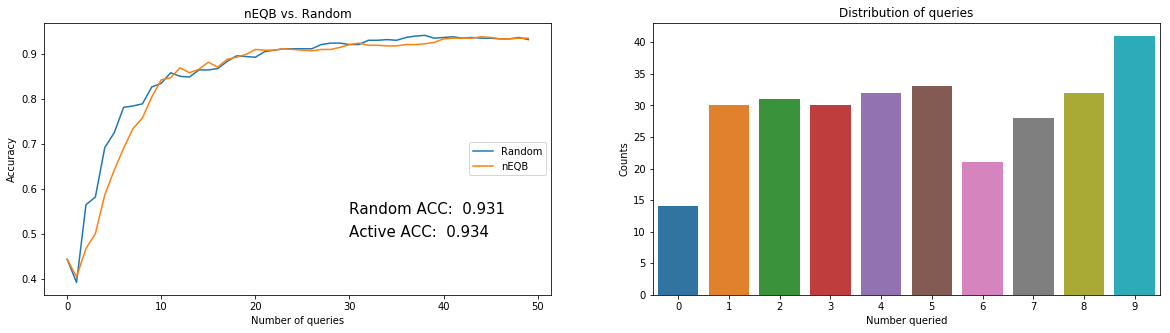

In [21]:
al_object_nEQB, label_nEQB = classifier_nEQB(X_test, y_test, num_queries, query_points, active)
full_plots(al_object_rand, label_rand, al_object_nEQB, label_nEQB)

## Diversity criteria

The points queried in the active learning methods are selectec by a concrete algorithm, this generates an ordering and we select the ones with highest rank. However this approach can result in querying too many similar points, so we can add to the models a diversity criterium that helps the get some variety in the queries.

### MAO

In this method, known as Most Ambiguous and Orthogonal (MAO), starting from the samples selected by the Active Learning algorithm, we choose the samples minimizing the distance between the candidates list and the samples already included in the labeled set. In order to avoid nonlinearities we are going to use a Kernel as a general measure of distance.

In [22]:
def diversity_MAO(active, idx, dist, query_points):
    
    label = "MAO"

    # Compute distances
    K = rbf_kernel(active.xunlab, gamma = active.gamma)
    
    idx_MAO = np.zeros(query_points, dtype=type(idx[0]))
    for i in range(query_points):
        # Save best point
        idx_MAO[i] = idx[0]
        idx = idx[1:]
        
        # Study distances
        Kdist = K[idx_MAO[:(i+1)],:][:,idx]
        Kdist = Kdist.min(axis = 0)
        
        # Reorder points
        idx = idx[Kdist.argsort(axis = 0)]
        
    return idx_MAO, label, active

### Lambda function

In this method we are going to combine the raw method without diversity criterium and the model with the MAO criterium through a ponderate sum of both results.

In [23]:
def diversity_lambda(active, idx, dist, query_points, lamb = 0.6):
    
    label = "Lambda"
    
    # Compute distances
    K = rbf_kernel(active.xunlab, gamma = active.gamma)
    
    idx_lamd = np.zeros(query_points, dtype=type(idx[0]))
    for j in range(query_points):
        # Save best point
        idx_lamd[j] = idx[0]
        idx = idx[1:]
        
        # Study distances
        Kdist = np.abs(K[idx_lamd[:(j+1)],:][:,idx])
        Kdist = Kdist.min(axis = 0)

        # Define a heuristic
        heuristic = np.array([dist[j] for j in idx]) * lamb + Kdist * (1 - lamb)
        
        # Reorder points
        idx = idx[heuristic.argsort(axis = 0)]
        
    return idx_lamd, label, active

### Clustering

Finally, the clustering diversity method ensures the diversity of the samples in the query by performing clustering in the frature space and then querying one point of each cluster.

In [24]:
def diversity_clustering(active, idx, dist, query_points):
    
    label = "Clustering"
    
    # Create the clusters
    kmeans = KMeans(n_clusters = min(query_points, len(active.xunlab[idx])))
    clusterIDs = kmeans.fit_predict(active.xunlab[idx])
    
    idx_clust = np.zeros(query_points, dtype=type(idx[0]))
    for j in np.arange(query_points):
        idx_clust[j] = idx[clusterIDs == j][0]
        
    return idx_clust, label, active

# Global function

The goal of this project is to develop a function that allow us to apply active learing methods by selection, with a diversity criterium also by selection. We first built the diversity criterium selection function

In [25]:
def select_criterium(criterium, active, idx, dist, query_points):
    if criterium == None:
        idx_div = idx
        label = "" 
        active = active
    elif criterium == "MAO":
        idx_div, label, active = diversity_MAO(active, idx, dist, query_points)
    elif criterium == "Lambda":
        idx_div, label, active = diversity_lambda(active, idx, dist, query_points, 0.6)
    elif criterium == "Clustering":
        idx_div, label, active = diversity_clustering(active, idx, dist, query_points)
    else:
        return print("This is not a valid criterium, the available options are None, MAO, Lambda and Clustering")
    
    return idx_div, label, active

then we adapt the active learning functions to implement these criteria

In [26]:
def classifier_MS(X_test, y_test, num_queries, query_points, active_object, criterium):
    
    label = "MS"
    active = active_object.copy()
    for i in range(num_queries):
        
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        dist = np.abs(active.classifier.decision_function(active.xunlab))
        dist = np.sort(dist, axis=1)
        dist = [d[0] for d in dist]
        idx = np.argsort(dist, axis = 0)
        
        # Apply diversity criterium
        idx_div, label_div, active = select_criterium(criterium, active, idx, dist, query_points)
        
        # Update the training set
        active.updateLabels(idx_div[:query_points])
    
    label = label + " + " + label_div
    
    return active, label




def classifier_MCLU(X_test, y_test, num_queries, query_points, active_object, criterium):
    
    label = "MCLU"
    active = active_object.copy()
    for i in range(num_queries):
        
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        dist = np.abs(active.classifier.decision_function(active.xunlab))
        dist = np.sort(dist, axis = 1)
        dist = [d[1] - d[0] for d in dist][::-1]
        idx = np.argsort(dist, axis = 0)

        # Apply diversity criterium
        idx_div, label_div, active = select_criterium(criterium, active, idx, dist, query_points)
        
        # Update the training set
        active.updateLabels(idx_div[:query_points])
    
    label = label + " + " + label_div
    
    return active, label




def classifier_SSC(X_test, y_test, num_queries, query_points, active_object, criterium):
    
    label = "SSC"
    active = active_object.copy()
    model = SVC(C = active.C, gamma = active.gamma)
    for i in range(num_queries):
        
        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
        
        # Choose the points to query
        xtr = active.xlab
        ytr = np.zeros(active.ylab.shape)
        ytr[active.classifier.support_] = 1
        
        if len(np.unique(ytr)) == 1:
            idx = np.random.permutation(active.xunlab.shape[0])
        else:
            model.fit(xtr, ytr)
            possible_SVs = model.predict(active.xunlab)
            idx = np.arange(active.xunlab.shape[0])[possible_SVs == 1]
            idx = np.random.permutation(idx)
        
        # Apply diversity criterium
        dist = np.abs(active.classifier.decision_function(active.xunlab))
        dist = np.sort(dist, axis=1)
        dist = [d[0] for d in dist]

        idx_div, label_div, active = select_criterium(criterium, active, idx, dist, query_points)
        
        # Update the training set
        active.updateLabels(idx_div[:query_points])
    
    label = label + " + " + label_div
    
    return active, label




def classifier_nEQB(X_test, y_test, num_queries, query_points, active_object, criterium, n_models = 10):
    
    label = "nEQB"
    active = active_object.copy()
    model = SVC(C = active.C, gamma = active.gamma)
    
    for i in range(num_queries):

        # Fit and save the accuracy
        active.classifier.fit(active.xlab, active.ylab)
        acc = active.classifier.score(X_test, y_test)
        active.acc.append(acc)
            
        # Choose the points to query
        n_unlab = active.xunlab.shape[0]
        predMatrix = np.zeros((n_unlab, n_models))
        
        for k in range(n_models):
            
            # Bootstrap
            while True:
                X_bag, y_bag = resample(active.xlab, active.ylab, replace = True)
                
                # Ensure that we have all classes in the bootstrap replica
                if len(np.unique(y_bag)) >= n_classes:
                    break
                    
            model.fit(X_bag, y_bag)
            predMatrix[:, k] = model.predict(active.xunlab)

        # Count number of votes per class
        ct = np.zeros((active.xunlab.shape[0], n_classes))
        for i, w in enumerate(np.unique(y_bag)):
            ct[:, i] = np.sum(predMatrix == w, axis=1)
        ct = ct / n_models
        Hbag = ct.copy()
        
        # Compute entropy
        Hbag[Hbag == 0] = 1 
        Hbag = -np.sum(ct * np.log(Hbag), axis=1)
        logNi = np.log(np.sum(ct > 0, axis=1))
        logNi[logNi == 0] = 1

        nEQB = Hbag / logNi
        
        # Order the elements by entropy
        idx = np.argsort(nEQB)[::-1]

        # Apply diversity criterium
        dist = nEQB
        idx_div, label_div, active = select_criterium(criterium, active, idx, dist, query_points)
        
        # Update the training set
        active.updateLabels(idx_div[:query_points])
    
    label = label + " + " + label_div
    
    return active, label

and finally we define the global function 

In [27]:
def active_learning_function(X_test, y_test, num_queries, query_points, active, method, criterium):
    
    # Create the random method
    al_object_rand, label_rand = classifier_random(X_test, y_test, num_queries, query_points, random)
    
    # Select the active method
    if method == "MS":
        al_object_al, label_al = classifier_MS(X_test, y_test, num_queries, query_points, active, criterium)
    elif method == "MCLU":
        al_object_al, label_al  = classifier_MCLU(X_test, y_test, num_queries, query_points, active, criterium)
    elif method == "SSC":
        al_object_al, label_al  = classifier_SSC(X_test, y_test, num_queries, query_points, active, criterium)
    elif method == "nEQB":
        al_object_al, label_al  = classifier_nEQB(X_test, y_test, num_queries, query_points, active, criterium, 10)
    else:
        return print("This is not a valid method, the available options are MS, MCLU, SSC and nEQB")
    
    return al_object_rand, label_rand, al_object_al, label_al

# Comparation

Now we are going to compare the methods, and since all of them are subject to some degree of randomness we are evaluating each model `n_reps = 50` times. Done this we can plot the mean and the standard deviation of the accuracy of each model in order to compare them

In [34]:
n_reps = 50

methods = ["MS", "MCLU", "SSC", "nEQB"] 
criteria = [None, "MAO","Lambda", "Clustering"]

to_plot = []
for method in methods:
    print(method)
    for criterium in criteria:  
        acc_rand_list = []
        acc_active_list = []
        print(criterium)
        for i in range(n_reps):
            al_object_rand, label_rand, al_object_active, label_active = active_learning_function(X_test, y_test, num_queries, query_points, active, method, criterium)
            
            acc_rand_list.append(al_object_rand.acc)
            acc_active_list.append(al_object_active.acc)
            print("Iteration",i,end="\r")
        
        rand_mean = np.mean(acc_rand_list, axis = 0)
        rand_std = np.std(acc_rand_list, axis = 0)
        active_mean = np.mean(acc_active_list, axis = 0)
        active_std = np.std(acc_active_list, axis = 0)
        
        to_plot.append([method, criterium, rand_mean, rand_std, active_mean, active_std])

MS
None
MAOration 49
Lambdaion 49
Clustering49
MCLUation 49
None
MAOration 49
Lambdaion 49
Clustering49
SSCration 49
None
MAOration 49
Lambdaion 49
Clustering49
nEQBation 49
None
MAOration 49
Lambdaion 49
Clustering49


and doing such representation

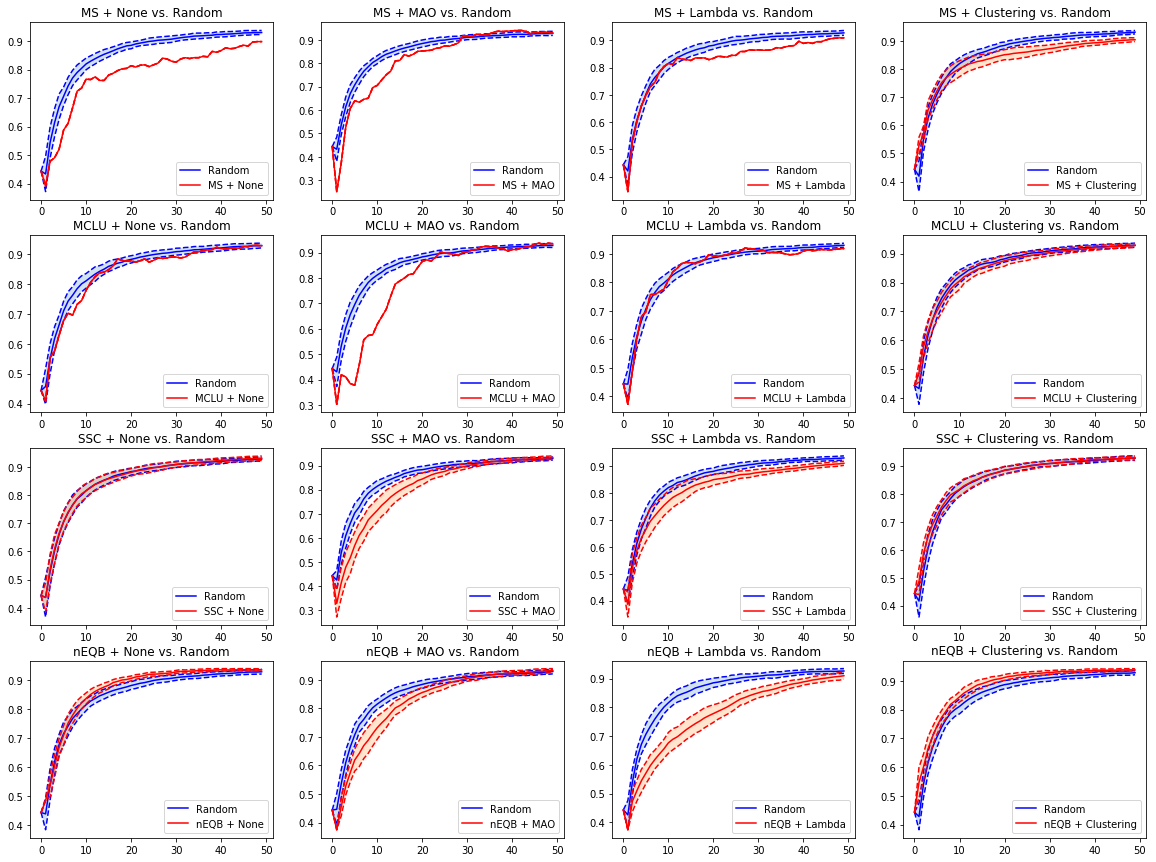

In [35]:
plt.figure(figsize=(20,15))
for i in range(len(to_plot)):
    things = to_plot[i]
    plt.subplot(4,4,i+1)
    
    # Plot random model accuracy
    plt.plot(things[2], label = "Random", c = "b")
    plt.plot(things[2] + things[3], 'b--')
    plt.plot(things[2] - things[3], 'b--')
    plt.fill_between(np.arange(num_queries), things[2] + things[3], things[2] - things[3], alpha=0.2)
    
    # Plot active model accuracy
    plt.plot(things[4], label = "{} + {}".format(things[0], things[1]), c = "r")
    plt.plot(things[4] + things[5], 'r--')
    plt.plot(things[4] - things[5], 'r--')
    plt.fill_between(np.arange(num_queries), things[4] + things[5], things[4] - things[5], alpha=0.2)
    
    # Label the plot and make a legend
    plt.title("{} + {} vs. Random".format(things[0], things[1]))
    plt.legend(loc = "lower right")
plt.show()

so we can see that the majority of the active learning methods does not perform better than a random query for the labels in this dataset. Only the nEQB method seems to improve the random one for this pair of `num_queries` and `query_points` values. Another analysis that can be done in the future will not only inlude comparation between active learning stategies but also an study of how the number of queried points at a time can affect the performance of the methods.